## Visualizing results -  Original Geoparser - First Edition

We have run the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to extract and resolvoe locations contained within the **First Edition, Volume 1, A-B** (year 1771) of the *Encyclopaedia Britannica*. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_first_edition nls defoe.nls.queries.geoparser_pages -r geoparser_original_EB_first_edition -n 16`



### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(df_group_places):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['place_label']))
    plt.bar(index, df_group_places['count'], color='orange')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['place_label'], rotation=40, fontsize=8)
    plt.title('15 Places most mentioned in the using the Original Geoparser')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages indicated in the query
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original geotagging of the Edinburgh geoparser. 
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
 - edition: First edition, 1771, Volume 1, A-B
 - georesolution_page:
    - SCOTLAND-rb3:
         - '33.64836'
         - '-98.46944999999999'
  - lang_model: geoparser_original
  - page_filename: alto/188082826.34.xml
  - text_unit id: Page9
  - year: 1771

In [7]:
results=read_query_results('geoparser_original_EB_first_edition')

In [8]:
df_total= geresolution_dataframe(results)

In [9]:
df_total[["Place"]].count()

Place    39523
dtype: int64

In [10]:
df_total["Place"]= df_total["Place"].str.capitalize()

In [11]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
Aable,2,2,2
Aach,2,2,2
Aade,2,2,2
Aar,2,2,2
Aat,1,1,1
Abaca,1,1,1
Abach,2,2,2
Abaco,2,2,2
Abadan,2,2,2


In [12]:
#df_total.groupby("Page").count()

In [13]:
#df_total.groupby(["Latitude", "Longitude"]).count()

In [14]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

df_max_geolocations = df_filter.drop(0)

df_max_geolocations.head(15)


,Latitude,Longitude,count
1726,34.6120507,-82.765139,442
2870,39.2528795,-77.6969362,394
3054,39.7528767,-77.1330392,391
4697,43.2256251,-75.48878740000001,274
2653,38.8873341,-77.05553279999999,274
5377,45.43861,12.32667,266
2889,39.2867738,-76.6010777,259
4129,41.9291973,-87.86200650000001,236
5319,45.2535999,-86.9795592,219
2607,38.7937266,-77.8577722,214


In [15]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Jupiter', 'Venus, a d p', 'Saturn']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)
    

0 442 France
1 394 Britain
2 391 Germany
3 274 Rome
4 274 Scotland
5 266 Venice
6 259 Italy
7 236 America
8 219 Europe
9 214 England
10 211 Asia
11 190 Europe
12 183 Paris
13 181 Africa
14 180 France
15 151 Naples
16 149 India


In [17]:
#Visualizing the 15 places in a Bar plot
df_places = {'place_label':place_label,'place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['place_label'])['place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,place_label,count
6,France,622
5,Europe,409
3,Britain,394
7,Germany,391
12,Rome,274
13,Scotland,274
14,Venice,266
9,Italy,259
1,America,236
4,England,214


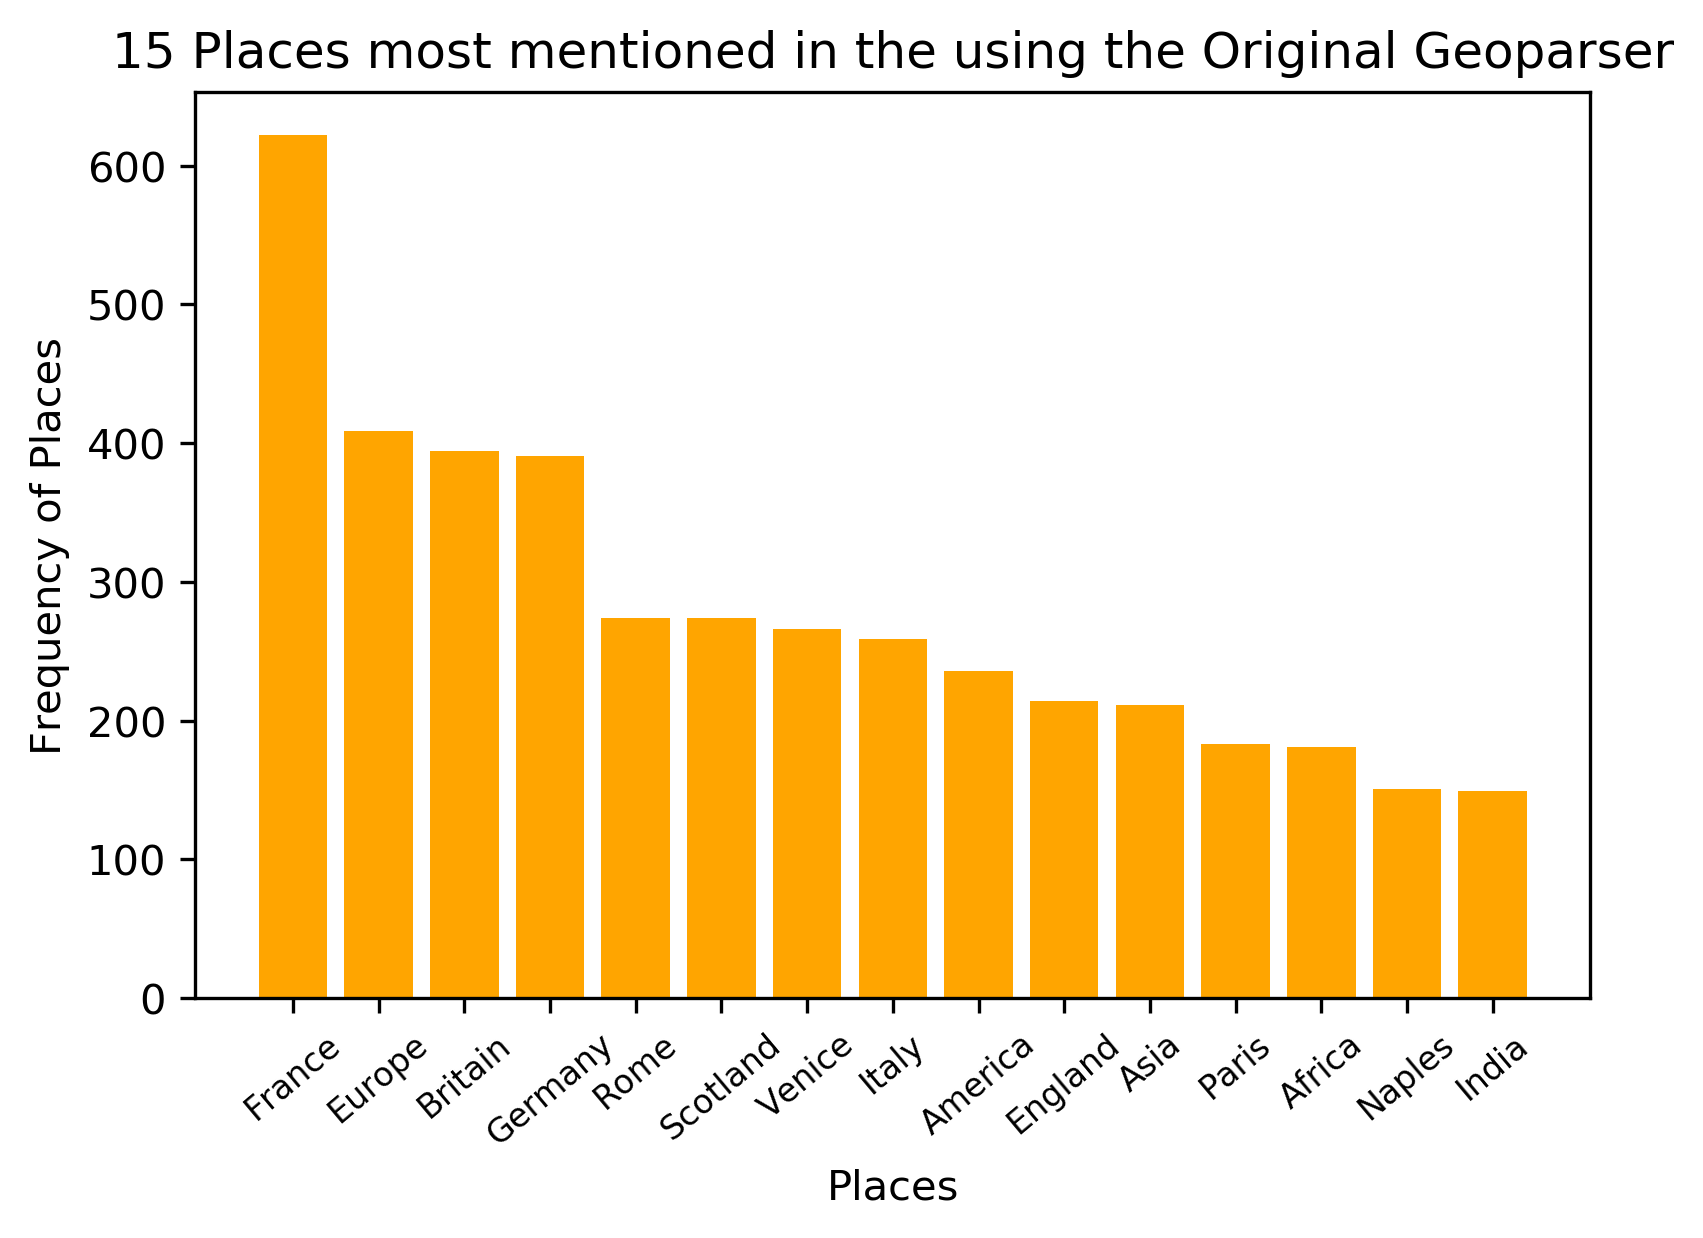

In [18]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places)